In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from RandomForestForTimeSeriesRegressor import RandomForestForTimeSeriesRegressor, BLOCK_TYPES

In [2]:
dataset = pd.read_csv('sp500_enriquecido.csv')

In [3]:
dataset = dataset.dropna()
dataset

,Date,DateOrdinal,average_price,DayOfWeek,DayOfYear,WeekOfYear,is_start_of_month,is_end_of_month,quarter,SerieNumber,...,Down_Last_14,Up_Streak,Down_Streak,Max_Up_Streak_30,Max_Down_Streak_30,SMA_30,Disparity_SMA_30,EMA_30,Trend_Slope_30,Volatility_30
0,2018-01-02,20180102,2689.125,1,2,1,0,0,1,17533,...,5.0,1,0,5.0,2.0,2644.685500,1.443631,2648.708053,3.948860,19.691816
1,2018-01-03,20180103,2706.070,2,3,1,0,0,1,17534,...,4.0,2,0,5.0,2.0,2648.272333,1.542616,2651.315598,3.799942,19.772879
2,2018-01-04,20180104,2724.180,3,4,1,0,0,1,17535,...,3.0,3,0,5.0,2.0,2652.448333,2.021591,2654.848140,3.707435,21.060779
3,2018-01-05,20180105,2735.685,4,5,1,0,0,1,17536,...,3.0,4,0,5.0,2.0,2657.206333,2.520454,2659.321163,3.680507,22.689070
4,2018-01-08,20180108,2743.055,0,8,2,0,0,1,17539,...,2.0,5,0,5.0,2.0,2661.889833,2.772285,2664.247863,3.759053,20.418188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,2020-12-24,20201224,3696.570,3,359,52,0,0,4,18620,...,4.0,0,1,5.0,3.0,3642.859667,1.575694,3632.942944,5.101103,28.809934
752,2020-12-28,20201228,3731.770,0,363,53,0,0,4,18624,...,3.0,1,0,4.0,3.0,3647.109333,1.356161,3637.047915,4.938796,23.823202
753,2020-12-29,20201229,3739.715,1,364,53,0,0,4,18625,...,3.0,2,0,4.0,3.0,3653.375000,2.145824,3643.159018,4.772516,26.043121
754,2020-12-30,20201230,3737.420,2,365,53,0,0,4,18626,...,3.0,0,1,4.0,3.0,3658.928333,2.207932,3649.388436,4.776031,28.394990


In [4]:
calculatedFields = [col for col in dataset.columns if col not in ['Date', 'average_price']]
fieldsPrice = ["average_price"]
dataset['Date'] = pd.to_datetime(dataset['Date'])

In [5]:
from datetime import datetime

pivote_date = datetime.strptime("01/01/2018", "%d/%m/%Y")
max_train_day = datetime.strptime("31/12/2018", "%d/%m/%Y") #pivote_date + pd.DateOffset(days=1825)
max_day = datetime.strptime("31/12/2020", "%d/%m/%Y")
max_test_1 = datetime.strptime("30/06/2019", "%d/%m/%Y")
max_test_2 = datetime.strptime("31/12/2019", "%d/%m/%Y")
max_test_3 = datetime.strptime("31/03/2019", "%d/%m/%Y")
trainBlock = dataset[(dataset['Date'] >= pivote_date) & (dataset['Date'] <= max_train_day)]

testBlock_6months = dataset[(dataset['Date'] > max_train_day) & (dataset['Date'] <= max_test_1)] 
testBlock_1year = dataset[(dataset['Date'] > max_train_day) & (dataset['Date'] <= max_test_2)] 
testBlock_2years = dataset[(dataset['Date'] > max_train_day) & (dataset['Date'] <= max_test_3)] 

trainBlock

,Date,DateOrdinal,average_price,DayOfWeek,DayOfYear,WeekOfYear,is_start_of_month,is_end_of_month,quarter,SerieNumber,...,Down_Last_14,Up_Streak,Down_Streak,Max_Up_Streak_30,Max_Down_Streak_30,SMA_30,Disparity_SMA_30,EMA_30,Trend_Slope_30,Volatility_30
0,2018-01-02,20180102,2689.125,1,2,1,0,0,1,17533,...,5.0,1,0,5.0,2.0,2644.685500,1.443631,2648.708053,3.948860,19.691816
1,2018-01-03,20180103,2706.070,2,3,1,0,0,1,17534,...,4.0,2,0,5.0,2.0,2648.272333,1.542616,2651.315598,3.799942,19.772879
2,2018-01-04,20180104,2724.180,3,4,1,0,0,1,17535,...,3.0,3,0,5.0,2.0,2652.448333,2.021591,2654.848140,3.707435,21.060779
3,2018-01-05,20180105,2735.685,4,5,1,0,0,1,17536,...,3.0,4,0,5.0,2.0,2657.206333,2.520454,2659.321163,3.680507,22.689070
4,2018-01-08,20180108,2743.055,0,8,2,0,0,1,17539,...,2.0,5,0,5.0,2.0,2661.889833,2.772285,2664.247863,3.759053,20.418188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2018-12-24,20181224,2380.720,0,358,52,0,0,4,17889,...,8.0,0,8,6.0,7.0,2668.099500,-7.931470,2647.877930,-7.622953,90.616685
247,2018-12-26,20181226,2407.170,2,360,52,0,0,4,17891,...,8.0,1,0,6.0,8.0,2653.961167,-10.295598,2630.641935,-8.533770,105.607906
248,2018-12-27,20181227,2443.520,3,361,52,0,0,4,17892,...,8.0,2,0,6.0,8.0,2641.561167,-8.873206,2616.224391,-9.262462,116.075663
249,2018-12-28,20181228,2496.580,4,362,52,0,0,4,17893,...,7.0,3,0,6.0,8.0,2631.378667,-7.139173,2605.082172,-9.799224,121.352528


In [6]:
aux = trainBlock.copy()
aux = aux.drop("Date", axis=1)
X_train = aux[calculatedFields].copy()
aux = aux.drop(calculatedFields, axis=1)

Y_train = aux[fieldsPrice].copy()

aux = testBlock_6months.copy()
aux = aux.drop("Date", axis=1)
X_test = aux[calculatedFields].copy()

aux = aux.drop(calculatedFields, axis=1)
Y_test = aux[fieldsPrice].copy()

aux = testBlock_1year.copy()
aux = aux.drop("Date", axis=1)
X_test_1y = aux[calculatedFields].copy()

aux = aux.drop(calculatedFields, axis=1)
Y_test_1y = aux[fieldsPrice].copy()

aux = testBlock_2years.copy()
aux = aux.drop("Date", axis=1)
X_test_2y = aux[calculatedFields].copy()

aux = aux.drop(calculatedFields, axis=1)
Y_test_2y = aux[fieldsPrice].copy()

In [7]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

basicRFPrecision = []
basicRFPrecision_1y = []
basicRFPrecision_2y = []
for i in range(50):
    basicRF = RandomForestRegressor(n_jobs=100, n_estimators=100, max_depth=10)
    basicRF.fit(X_train, Y_train)
    y_pred = basicRF.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    basicRFPrecision.append(rmse0)
    y_pred = basicRF.predict(X_test_1y)
    rmse0 = sqrt(mean_squared_error(Y_test_1y, y_pred))
    basicRFPrecision_1y.append(rmse0)
    y_pred = basicRF.predict(X_test_2y)
    rmse0 = sqrt(mean_squared_error(Y_test_2y, y_pred))
    basicRFPrecision_2y.append(rmse0)

In [9]:
# daysOfBlocks = 730
# daysOfTraining = 365
# X_train0, Y_train0, X_test0, Y_test0 = getRandomTrainTestData(dataset, daysOfBlocks, daysOfTraining)
#totalSamplesAprox = trainSamples #X_train.shape[0]
#blockSizes = [totalSamplesAprox / 100, totalSamplesAprox / 50, totalSamplesAprox / 20, totalSamplesAprox / 10, totalSamplesAprox / 5]
#for i in range(len(blockSizes)):
#    blockSizes[i] = int(blockSizes[i])
blockSizes = [5, 6, 7, 8, 9, 10, 20, 30, 50, 100, 200]  #, 300, 400] #[15, 30, 60, 150, 300]
#blockSizes = [15, 30, 60, 150, 300]


In [10]:
precisionNonOverlapping = dict()
precisionNonOverlapping_1y = dict()
precisionNonOverlapping_2y = dict()
for block_size in blockSizes:
    precisionNonOverlapping[block_size] = []
    precisionNonOverlapping_1y[block_size] = []
    precisionNonOverlapping_2y[block_size] = []
    for k in range(50):
        rfts = RandomForestForTimeSeriesRegressor(n_jobs=100, n_estimators=100, block_size=block_size, max_depth=10)
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
        precisionNonOverlapping[block_size].append(rmse0)
        y_pred = rfts.predict(X_test_1y)
        rmse0 = sqrt(mean_squared_error(Y_test_1y, y_pred))
        precisionNonOverlapping_1y[block_size].append(rmse0)
        y_pred = rfts.predict(X_test_2y)
        rmse0 = sqrt(mean_squared_error(Y_test_2y, y_pred))
        precisionNonOverlapping_2y[block_size].append(rmse0)

In [11]:
precisionMovingBlock = dict()
precisionMovingBlock_1y = dict()
precisionMovingBlock_2y = dict()
for block_size in blockSizes:
    precisionMovingBlock[block_size] = []
    precisionMovingBlock_1y[block_size] = []
    precisionMovingBlock_2y[block_size] = []
    for k in range(50):
        rfts = RandomForestForTimeSeriesRegressor(n_jobs=100, n_estimators=500, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[1])
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
        precisionMovingBlock[block_size].append(rmse0)
        y_pred = rfts.predict(X_test_1y)
        rmse0 = sqrt(mean_squared_error(Y_test_1y, y_pred))
        precisionMovingBlock_1y[block_size].append(rmse0)
        y_pred = rfts.predict(X_test_2y)
        rmse0 = sqrt(mean_squared_error(Y_test_2y, y_pred))
        precisionMovingBlock_2y[block_size].append(rmse0)

In [12]:
precisionCircularBlock = dict()
precisionCircularBlock_1y = dict()
precisionCircularBlock_2y = dict()
for block_size in blockSizes:
    precisionCircularBlock[block_size] = []
    precisionCircularBlock_1y[block_size] = []
    precisionCircularBlock_2y[block_size] = []
    for k in range(50):
        rfts = RandomForestForTimeSeriesRegressor(n_jobs=100, n_estimators=100, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[2])
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
        precisionCircularBlock[block_size].append(rmse0)
        y_pred = rfts.predict(X_test_1y)
        rmse0 = sqrt(mean_squared_error(Y_test_1y, y_pred))
        precisionCircularBlock_1y[block_size].append(rmse0)
        y_pred = rfts.predict(X_test_2y)
        rmse0 = sqrt(mean_squared_error(Y_test_2y, y_pred))
        precisionCircularBlock_2y[block_size].append(rmse0)

In [13]:
def getGraphData(presitionDataArray):
    all_arr = [[]]
    ticksIdx = [0]
    ticksNames = ["RF"]
    idx = 0
    for blockSize in blockSizes:
        
        data0 = []
        for r in presitionDataArray[blockSize]:
            data0.append(r)

        all_arr.append(data0)
        idx += 1
        ticksIdx.append(idx)
        ticksNames.append(str(blockSize))

    return all_arr, ticksIdx, ticksNames

In [14]:
rf_array = [basicRFPrecision]
rf_array_1y = [basicRFPrecision_1y]
rf_array_2y = [basicRFPrecision_2y]
for i in range(1, len(precisionNonOverlapping)):
    rf_array.append([])
    rf_array_1y.append([])
    rf_array_2y.append([])

Text(38.222222222222214, 0.5, 'RMSE')

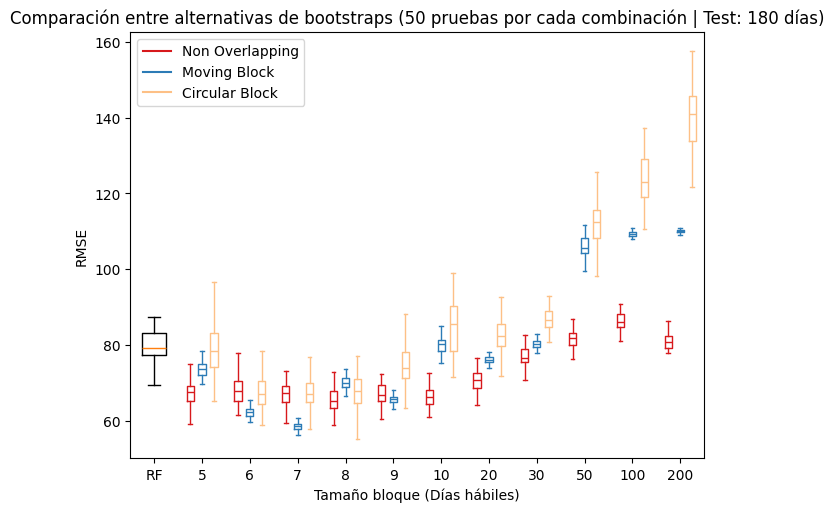

In [15]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionNonOverlapping)
all_arr1, ticksIdx, ticksNames = getGraphData(precisionMovingBlock)
all_arr2, ticksIdx, ticksNames = getGraphData(precisionCircularBlock)

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bp0 = plt.boxplot(all_arr, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.boxplot(all_arr1, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.boxplot(all_arr2, positions=np.array(range(len(all_arr1)))*2.0+0.5, sym='', widths=0.3)
bp_1 = plt.boxplot(rf_array, positions=np.array(range(len(rf_array))), sym='', widths=1)
set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bp1, '#2C7BB6')
set_box_color(bp2, '#fdc086')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Non Overlapping')
plt.plot([], c='#2C7BB6', label='Moving Block')
plt.plot([], c='#fdc086', label='Circular Block')
plt.legend()

plt.xticks(range(0, len(ticksNames) * 2, 2), ticksNames)
# plt.xlim(-2, len(ticks)*2)
#plt.ylim(34, 55)
plt.tight_layout()
plt.title("Comparación entre alternativas de bootstraps (50 pruebas por cada combinación | Test: 180 días)")
plt.xlabel("Tamaño bloque (Días hábiles)")
plt.ylabel("RMSE")

In [21]:
def calcular_variabilidad(nombre, lista_arrays):
    resultados = []
    for i, arr in enumerate(lista_arrays):

        if len(arr) == 0:
            continue  # Saltar arrays vacíos

        arr = np.array(arr)
        q1 = np.percentile(arr, 25)
        q3 = np.percentile(arr, 75)
        iqr = q3 - q1
        std = np.std(arr)
        rango = np.max(arr) - np.min(arr)
        resultados.append({
            'Grupo': f"{nombre}_{i}",
            'IQR': iqr,
            'STD': std,
            'Rango': rango
        })
    return resultados

# Calcular para cada grupo
res0 = calcular_variabilidad('RFTS Non-Overlaping', all_arr)
res1 = calcular_variabilidad('RFTS Moving-Block', all_arr1)
res2 = calcular_variabilidad('RFTS Circular-Block', all_arr2)
res3 = calcular_variabilidad('Random Forest', rf_array)

# Combinar en DataFrame
tabla_variabilidad = pd.DataFrame(res0 + res1 + res2 + res3)

# Mostrar tabla
#print(tabla_variabilidad)

In [17]:
def promedios_por_subarray(nombre, lista):
    resultados = []
    for i, arr in enumerate(lista):

        if len(arr) == 0:
            resultados.append(0)
            continue  # Saltar arrays vacíos

        arr = np.array(arr)
        q1 = np.percentile(arr, 25)
        q3 = np.percentile(arr, 75)
        iqr = q3 - q1
        std = np.std(arr)
        rango = np.max(arr) - np.min(arr)
        resultados.append(rango)
    return pd.Series(resultados)
    

# Crear columnas con los promedios
col_all_arr  = promedios_por_subarray('RFTS Non-Overlaping', all_arr)
col_all_arr1 = promedios_por_subarray('RFTS Moving-Block', all_arr1)
col_all_arr2 = promedios_por_subarray('RFTS Circular-Block', all_arr2)
col_rf_array = promedios_por_subarray('Random Forest', rf_array)

# Combinar en DataFrame
df_promedios = pd.concat([col_all_arr, col_all_arr1, col_all_arr2, col_rf_array], axis=1)
df_promedios.insert(0, 'Tamaños de bloques', ticksNames)

print(df_promedios)

   Tamaños de bloques          0          1          2          3
0                  RF   0.000000   0.000000   0.000000  18.163488
1                   5  19.327930   8.822641  40.203249   0.000000
2                   6  16.445783   5.695873  19.541759   0.000000
3                   7  19.101093   4.516134  23.029846   0.000000
4                   8  13.847019   7.152773  27.861859   0.000000
5                   9  11.968682   5.170673  24.854158   0.000000
6                  10  15.810741  11.414053  27.356409   0.000000
7                  20  12.368888   4.139837  25.067018   0.000000
8                  30  14.472977   4.919941  16.088556   0.000000
9                  50  14.158557  16.322242  30.192876   0.000000
10                100  13.060427   2.944017  26.489569   0.000000
11                200   8.704613   2.649393  35.925164        NaN


## Variabilidad de bloques con tamaño 6

In [ ]:
ultima_col = df_promedios.iloc[0, -1]

fila_datos = df_promedios.iloc[2, :-1]

nombres_algoritmos = ["Tamaño bloque", "RFTS Non-Overlaping", "RFTS Moving-Block", "RFTS Circular-Block", "Random Forest"]
nombres_algoritmos0 = ["RFTS Non-Overlaping", "RFTS Moving-Block", "RFTS Circular-Block", "Random Forest"]

# Crear un nuevo DataFrame con los datos y la versión reducida del nombre
nueva_fila = pd.DataFrame([fila_datos.tolist() + [ultima_col]], columns=nombres_algoritmos)

nueva_fila

,Tamaño bloque,RFTS Non-Overlaping,RFTS Moving-Block,RFTS Circular-Block,Random Forest
0,6,16.445783,5.695873,19.541759,18.163488


Text(38.222222222222214, 0.5, 'RMSE')

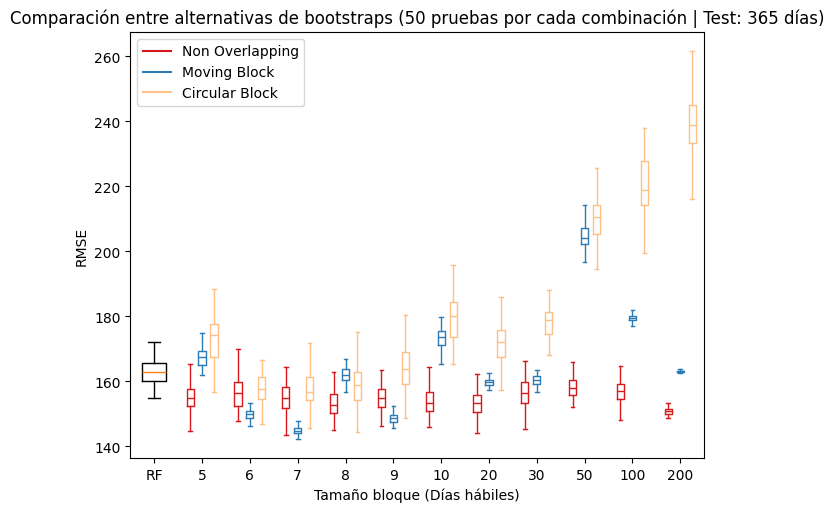

In [19]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionNonOverlapping_1y)
all_arr1, ticksIdx, ticksNames = getGraphData(precisionMovingBlock_1y)
all_arr2, ticksIdx, ticksNames = getGraphData(precisionCircularBlock_1y)

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bp0 = plt.boxplot(all_arr, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.boxplot(all_arr1, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.boxplot(all_arr2, positions=np.array(range(len(all_arr1)))*2.0+0.5, sym='', widths=0.3)
bp_1 = plt.boxplot(rf_array_1y, positions=np.array(range(len(rf_array_1y))), sym='', widths=1)
set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bp1, '#2C7BB6')
set_box_color(bp2, '#fdc086')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Non Overlapping')
plt.plot([], c='#2C7BB6', label='Moving Block')
plt.plot([], c='#fdc086', label='Circular Block')
plt.legend()

plt.xticks(range(0, len(ticksNames) * 2, 2), ticksNames)
# plt.xlim(-2, len(ticks)*2)
#plt.ylim(34, 55)
plt.tight_layout()
plt.title("Comparación entre alternativas de bootstraps (50 pruebas por cada combinación | Test: 365 días)")
plt.xlabel("Tamaño bloque (Días hábiles)")
plt.ylabel("RMSE")

Text(38.222222222222214, 0.5, 'RMSE')

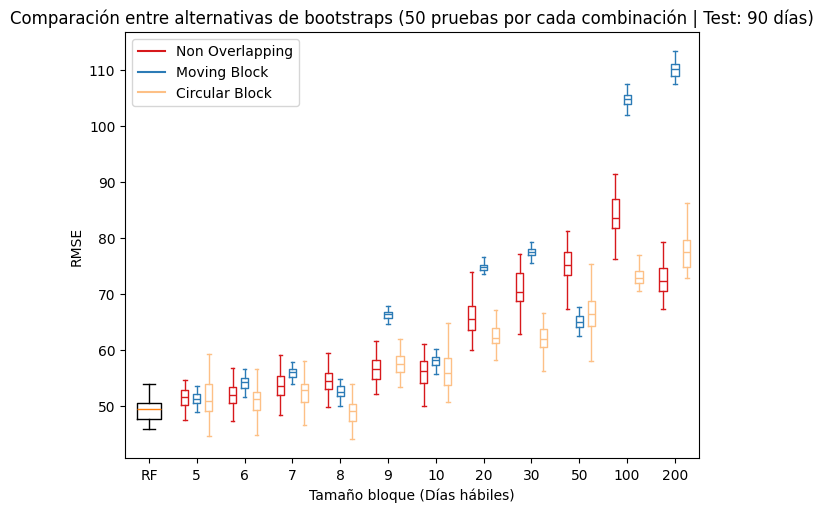

In [20]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionNonOverlapping_2y)
all_arr1, ticksIdx, ticksNames = getGraphData(precisionMovingBlock_2y)
all_arr2, ticksIdx, ticksNames = getGraphData(precisionCircularBlock_2y)

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bp0 = plt.boxplot(all_arr, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.boxplot(all_arr1, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.boxplot(all_arr2, positions=np.array(range(len(all_arr1)))*2.0+0.5, sym='', widths=0.3)
bp_1 = plt.boxplot(rf_array_2y, positions=np.array(range(len(rf_array_2y))), sym='', widths=1)
set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bp1, '#2C7BB6')
set_box_color(bp2, '#fdc086')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Non Overlapping')
plt.plot([], c='#2C7BB6', label='Moving Block')
plt.plot([], c='#fdc086', label='Circular Block')
plt.legend()

plt.xticks(range(0, len(ticksNames) * 2, 2), ticksNames)
# plt.xlim(-2, len(ticks)*2)
#plt.ylim(34, 55)
plt.tight_layout()
plt.title("Comparación entre alternativas de bootstraps (50 pruebas por cada combinación | Test: 90 días)")
plt.xlabel("Tamaño bloque (Días hábiles)")
plt.ylabel("RMSE")